In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import load_model
from depth_anything_v2.dpt import DepthAnythingV2
from tqdm import tqdm
from tqdm.contrib import tzip


xFormers not available
xFormers not available
/home/jiahan/miniconda3/envs/depth-anything-v2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:

def infer_stich(model, image, depth_gt):
    # 4 个部分拼接起来
    h,w,_ = image.shape
    half_h, half_w = int(h/2), int(w/2)
    image1 = image[0:half_h, 0:half_w]
    image2 = image[0:half_h, half_w:]
    image3 = image[half_h:, 0:half_w]
    image4 = image[half_h:, half_w:]
    depth1 = model.infer_image(image1)
    depth2 = model.infer_image(image2)
    depth3 = model.infer_image(image3)
    depth4 = model.infer_image(image4)
    
    depth_stich = np.zeros_like(depth_gt)
    depth_stich[0:half_h, 0:half_w] = depth1
    depth_stich[0:half_h, half_w:] = depth2
    depth_stich[half_h:, 0:half_w] = depth3
    depth_stich[half_h:, half_w:] = depth4

    return depth_stich

def show_one(image, depth_gt, model, maxValue=200):
    depth = model.infer_image(image)
    h,w,_ = image.shape
    half_h, half_w = int(h/2), int(w/2)
    plt.figure()
    plt.imshow(image[...,::-1])

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("infer")
    plt.imshow(depth, vmax=maxValue)
    plt.subplot(1,3,2)
    plt.title("gt")
    plt.imshow(depth_gt, vmax=maxValue)

    # 4 个部分拼接起来
    image1 = image[0:half_h, 0:half_w]
    image2 = image[0:half_h, half_w:]
    image3 = image[half_h:, 0:half_w]
    image4 = image[half_h:, half_w:]
    depth1 = model.infer_image(image1)
    depth2 = model.infer_image(image2)
    depth3 = model.infer_image(image3)
    depth4 = model.infer_image(image4)
    depth_infer1 = depth[0:half_h, 0:half_w]
    depth_infer2 = depth[0:half_h, half_w:]
    depth_infer3 = depth[half_h:, 0:half_w]
    depth_infer4 = depth[half_h:, half_w:]

    depth_gt1 = depth_gt[0:half_h, 0:half_w]
    depth_gt2 = depth_gt[0:half_h, half_w:]
    depth_gt3 = depth_gt[half_h:, 0:half_w]
    depth_gt4 = depth_gt[half_h:, half_w:]

    depth_stich = np.zeros_like(depth_gt)
    depth_stich[0:half_h, 0:half_w] = depth1
    depth_stich[0:half_h, half_w:] = depth2
    depth_stich[half_h:, 0:half_w] = depth3
    depth_stich[half_h:, half_w:] = depth4
    plt.subplot(1,3,3)
    plt.imshow(depth_stich, vmax=maxValue)

    print("------ No stich -------")
    show_metric(depth, depth_gt)
    print("------ stich -------")
    show_metric(depth_stich, depth_gt)
    print("------ diff infer -------")
    show_metric(depth_stich, depth)

    plt.figure()
    plt.imshow(depth_stich)

    print("--------")
    print("=> LT")
    show_metric(depth1, depth_gt1)
    print("diff infer")
    show_metric(depth1, depth_infer1)
    print("=> RT")
    show_metric(depth2, depth_gt2)
    print("diff infer")
    show_metric(depth2, depth_infer2)
    print("=> LD")
    show_metric(depth3, depth_gt3)
    print("diff infer")
    show_metric(depth3, depth_infer3)
    print("=> RD")
    show_metric(depth4, depth_gt4)
    print("diff infer")
    show_metric(depth4, depth_infer4)


def show_one_swz(image, depth_gt, model, maxValue=200):
    depth = model.infer_image(image)
    h,w,_ = image.shape
    half_h, half_w = int(h/2), int(w/2)
    plt.figure()
    plt.imshow(image[...,::-1])

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("infer")
    plt.imshow(depth, vmax=maxValue)
    plt.subplot(1,3,2)
    plt.title("gt")
    plt.imshow(depth_gt, vmax=maxValue)

    # 4 个部分拼接起来
    image1 = image[0:half_h+20, 0:half_w+20]
    image2 = image[0:half_h+20, half_w-20:]
    image3 = image[half_h-20:, 0:half_w+20]
    image4 = image[half_h-20:, half_w-20:]
    depth1 = model.infer_image(image1)
    depth2 = model.infer_image(image2)
    depth3 = model.infer_image(image3)
    depth4 = model.infer_image(image4)
    depth_infer1 = depth[0:half_h, 0:half_w]
    depth_infer2 = depth[0:half_h, half_w:]
    depth_infer3 = depth[half_h:, 0:half_w]
    depth_infer4 = depth[half_h:, half_w:]

    depth_gt1 = depth_gt[0:half_h, 0:half_w]
    depth_gt2 = depth_gt[0:half_h, half_w:]
    depth_gt3 = depth_gt[half_h:, 0:half_w]
    depth_gt4 = depth_gt[half_h:, half_w:]

    depth_stich = np.zeros_like(depth_gt)
    depth_stich[0:half_h, 0:half_w] = depth1[0:half_h, 0:half_w]
    depth_stich[0:half_h, half_w:] = depth2[0:half_h, 20:]
    depth_stich[half_h:, 0:half_w] = depth3[20:, 0:half_w]
    depth_stich[half_h:, half_w:] = depth4[20:, 20:]
    plt.subplot(1,3,3)
    plt.imshow(depth_stich, vmax=maxValue)

    print("------ No stich -------")
    show_metric(depth, depth_gt)
    print("------ stich -------")
    show_metric(depth_stich, depth_gt)
    print("------ diff infer -------")
    show_metric(depth_stich, depth)

    plt.figure()
    plt.imshow(depth_stich)

    print("--------")
    print("=> LT")
    show_metric(depth1[0:half_h, 0:half_w], depth_gt1)
    print("diff infer")
    show_metric(depth1[0:half_h, 0:half_w], depth_infer1)
    print("=> RT")
    show_metric(depth2[0:half_h, 20:], depth_gt2)
    print("diff infer")
    show_metric(depth2[0:half_h, 20:], depth_infer2)
    print("=> LD")
    show_metric(depth3[20:, 0:half_w], depth_gt3)
    print("diff infer")
    show_metric(depth3[20:, 0:half_w], depth_infer3)
    print("=> RD")
    show_metric(depth4[20:, 20:], depth_gt4)
    print("diff infer")
    show_metric(depth4[20:, 20:], depth_infer4)


def show_metric(pred, gt):
    rmse = np.sqrt(np.mean((pred - gt) ** 2))
    mae = np.mean(np.abs(pred - gt))
    absrel = np.median(np.abs(pred - gt) / (gt+1e-6))
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"ABS REL: {absrel}")

def eval(image, gt, model):
    metrics = [0.0, 0.0, 0.0] # rmse mae absrel
    pred = model.infer_image(image)
    rmse = np.sqrt(np.mean((pred - gt) ** 2))
    mae = np.mean(np.abs(pred - gt))
    absrel = np.median(np.abs(pred - gt) / (gt+1e-6))
    metrics[0] = rmse
    metrics[1] = mae
    metrics[2] = absrel
    
    return metrics

def eval_sc(image, gt, model):
    metrics = [0.0, 0.0, 0.0] # rmse mae absrel
    image1 = image[0:128, 0:128]
    image2 = image[0:128, 128:]
    image3 = image[128:, 0:128]
    image4 = image[128:, 128:]
    depth1 = model.infer_image(image1)
    depth2 = model.infer_image(image2)
    depth3 = model.infer_image(image3)
    depth4 = model.infer_image(image4)
    depth_gt1 = gt[0:128, 0:128]
    depth_gt2 = gt[0:128, 128:]
    depth_gt3 = gt[128:, 0:128]
    depth_gt4 = gt[128:, 128:]
    depth_stich = np.zeros_like(gt)
    depth_stich[0:128, 0:128] = depth1
    depth_stich[0:128, 128:] = depth2
    depth_stich[128:, 0:128] = depth3
    depth_stich[128:, 128:] = depth4
    
    rmse = np.sqrt(np.mean((depth_stich - gt) ** 2))
    mae = np.mean(np.abs(depth_stich - gt))
    absrel = np.median(np.abs(depth_stich - gt) / (gt+1e-6))
    metrics[0] = rmse
    metrics[1] = mae
    metrics[2] = absrel
    
    metrics_LT = [0.0, 0.0, 0.0] # rmse mae absrel
    rmse = np.sqrt(np.mean((depth1 - depth_gt1) ** 2))
    mae = np.mean(np.abs(depth1 - depth_gt1))
    absrel = np.median(np.abs(depth1 - depth_gt1) / (depth_gt1+1e-6))
    metrics_LT[0] = rmse
    metrics_LT[1] = mae
    metrics_LT[2] = absrel
    
    metrics_RT = [0.0, 0.0, 0.0] # rmse mae absrel
    rmse = np.sqrt(np.mean((depth2 - depth_gt2) ** 2))
    mae = np.mean(np.abs(depth2 - depth_gt2))
    absrel = np.median(np.abs(depth2 - depth_gt2) / (depth_gt2+1e-6))
    metrics_RT[0] = rmse
    metrics_RT[1] = mae
    metrics_RT[2] = absrel
    
    metrics_LD = [0.0, 0.0, 0.0] # rmse mae absrel
    rmse = np.sqrt(np.mean((depth3 - depth_gt3) ** 2))
    mae = np.mean(np.abs(depth3 - depth_gt3))
    absrel = np.median(np.abs(depth3 - depth_gt3) / (depth_gt3+1e-6))
    metrics_LD[0] = rmse
    metrics_LD[1] = mae
    metrics_LD[2] = absrel
    
    metrics_RD = [0.0, 0.0, 0.0] # rmse mae absrel
    rmse = np.sqrt(np.mean((depth4 - depth_gt4) ** 2))
    mae = np.mean(np.abs(depth4 - depth_gt4))
    absrel = np.median(np.abs(depth4 - depth_gt4) / (depth_gt4+1e-6))
    metrics_RD[0] = rmse
    metrics_RD[1] = mae
    metrics_RD[2] = absrel
    
    return metrics, metrics_LT, metrics_RT, metrics_LD, metrics_RD

def read_txt(txtFile):
    with open(txtFile, 'r') as f:
        lines = f.readlines()
    lines = [line[:-1] for line in lines]
    gt_files, img_files = [], []
    for line in lines:
        tmp = line.split(" ")
        gt_files.append(tmp[0])
        img_files.append(tmp[1])
    
    return gt_files, img_files

def read_img(imgFile):
    return cv2.imread(imgFile)

def read_depth(depthFile):
    tmp = cv2.imread(depthFile, -1).astype(np.float32)
    tmp = 200 * tmp / 255.0
    return tmp

In [3]:
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

depth_anything = DepthAnythingV2(**{**model_configs['vits'], 'max_depth': 200})
# weight = torch.load("/home/jiahan/jiahan/codes/Depth-Anything-V2/tmp/2024-10-07_14-17-16/latest_4.pth", map_location='cpu') # aug 训练
weight = torch.load("/home/jiahan/jiahan/codes/Depth-Anything-V2/tmp/2024-10-11_14-53-03/latest_4.pth", map_location='cpu') # aug 训练，但是训练集图片数量为 0.8
if 'model' in weight.keys(): weight = weight['model']
else: pass

depth_anything.load_state_dict(weight)
depth_anything = depth_anything.to('cuda').eval()

/home/jiahan/miniconda3/envs/depth-anything-v2/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### 单张图

------ No stich -------
RMSE: 1.2374099493026733
MAE: 0.7475394606590271
ABS REL: 0.018053490668535233
------ stich -------
RMSE: 2.1579394340515137
MAE: 1.659665822982788
ABS REL: 0.04840318486094475
------ diff infer -------
RMSE: 1.828505277633667
MAE: 1.4117823839187622
ABS REL: 0.04301697760820389
--------
=> LT
RMSE: 1.6495085954666138
MAE: 1.238533854484558
ABS REL: 0.03243865445256233
diff infer
RMSE: 1.6169607639312744
MAE: 1.2444860935211182
ABS REL: 0.034736670553684235
=> RT
RMSE: 3.202054500579834
MAE: 2.4726054668426514
ABS REL: 0.05096541345119476
diff infer
RMSE: 2.6176018714904785
MAE: 2.0153915882110596
ABS REL: 0.04569785296916962
=> LD
RMSE: 2.028376579284668
MAE: 1.8742483854293823
ABS REL: 0.11281484365463257
diff infer
RMSE: 1.3842946290969849
MAE: 1.2298264503479004
ABS REL: 0.06246975064277649
=> RD
RMSE: 1.2403489351272583
MAE: 1.0532755851745605
ABS REL: 0.03367245942354202
diff infer
RMSE: 1.4110466241836548
MAE: 1.1574252843856812
ABS REL: 0.034363511949777

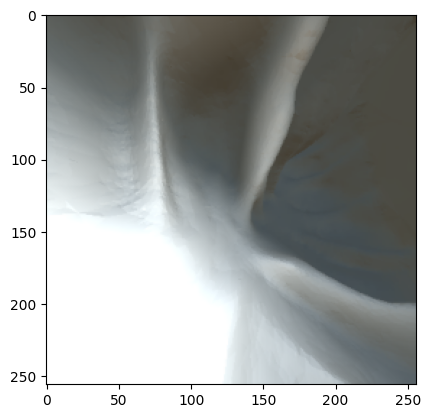

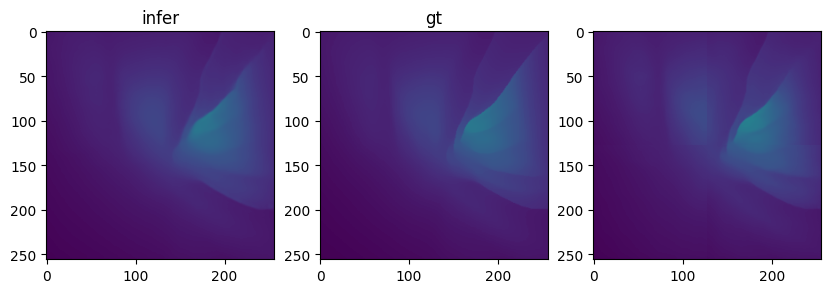

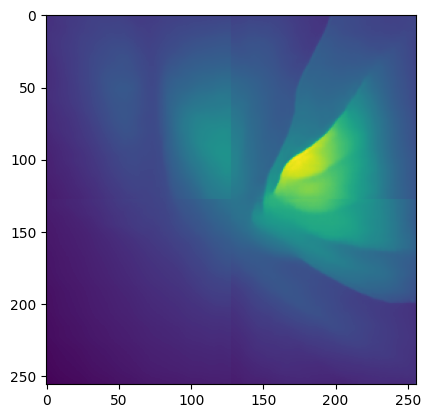

In [10]:
# aug训练的单张图

# image = cv2.imread("/Disk_2/Jiahan/T1/C_T3_L3_4_resized/FrameBuffer_0200.png")
image = cv2.imread("/Disk_2/Jiahan/T1/C_T3_L3_5_resized/FrameBuffer_0478.png")
depth_gt = 200 * cv2.imread("/Disk_2/Jiahan/T1/C_T3_L3_5_resized/Depth_0478.png", -1).astype(np.float32) / 255.0

show_one_swz(image, depth_gt, depth_anything)

------ No stich -------
RMSE: 1.0329171419143677
MAE: 0.6646997332572937
ABS REL: 0.016493618488311768
------ stich -------
RMSE: 7.724466323852539
MAE: 5.339231014251709
ABS REL: 0.13826602697372437
------ diff infer -------
RMSE: 7.645572185516357
MAE: 5.364107131958008
ABS REL: 0.14755834639072418
--------
=> LT
RMSE: 5.838027477264404
MAE: 4.773257255554199
ABS REL: 0.15402226150035858
diff infer
RMSE: 5.9240522384643555
MAE: 4.861776351928711
ABS REL: 0.15757301449775696
=> RT
RMSE: 12.319965362548828
MAE: 9.792901039123535
ABS REL: 0.21168279647827148
diff infer
RMSE: 11.918314933776855
MAE: 9.217313766479492
ABS REL: 0.18701377511024475
=> LD
RMSE: 3.1192946434020996
MAE: 2.241647720336914
ABS REL: 0.10719197988510132
diff infer
RMSE: 3.597346782684326
MAE: 2.8126723766326904
ABS REL: 0.14626482129096985
=> RD
RMSE: 6.563187122344971
MAE: 4.5491180419921875
ABS REL: 0.10580918937921524
diff infer
RMSE: 6.613438606262207
MAE: 4.564665794372559
ABS REL: 0.1035870835185051


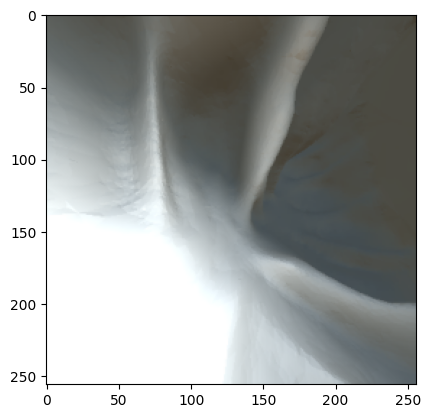

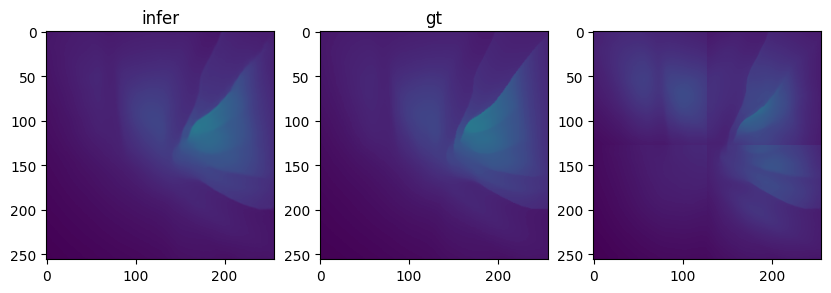

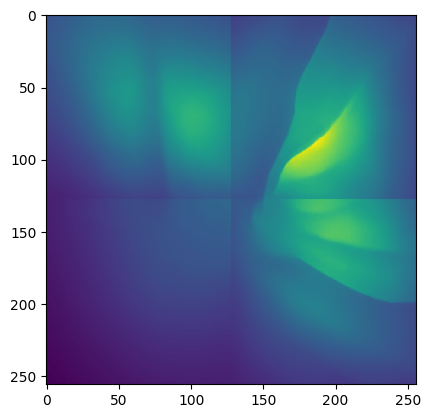

In [11]:
# base训练的单张图结果

model_base = DepthAnythingV2(**{**model_configs['vits'], 'max_depth': 200})
weight = torch.load("/home/jiahan/jiahan/codes/Depth-Anything-V2/tmp/2024-10-08_21-14-04/latest_4.pth", map_location='cpu')
if 'model' in weight.keys(): weight = weight['model']
else: pass
model_base.load_state_dict(weight)
model_base = model_base.to('cuda').eval()

image = cv2.imread("/Disk_2/Jiahan/T1/C_T3_L3_5_resized/FrameBuffer_0478.png")
depth_gt = 200 * cv2.imread("/Disk_2/Jiahan/T1/C_T3_L3_5_resized/Depth_0478.png", -1).astype(np.float32) / 255.0

show_one_swz(image, depth_gt, model_base)


------ No stich -------
RMSE: 7.340143981696986
MAE: 5.505146113127379
ABS REL: 0.12725329238752447
------ stich -------
RMSE: 10.796730872263668
MAE: 8.464846816709823
ABS REL: 0.21623948413671398
------ diff infer -------
RMSE: 7.868612533420216
MAE: 5.38110868160757
ABS REL: 0.11448796089185398
--------
=> LT
RMSE: 5.062363554638916
MAE: 4.018309584871539
ABS REL: 0.0878824779299057
diff infer
RMSE: 4.091407299041748
MAE: 3.5042967796325684
ABS REL: 0.09904059767723083
=> RT
RMSE: 8.650127799336088
MAE: 7.794349173091813
ABS REL: 0.40947547719092986
diff infer
RMSE: 4.864500045776367
MAE: 3.6584930419921875
ABS REL: 0.10738902539014816
=> LD
RMSE: 14.441393585101508
MAE: 12.303176491981054
ABS REL: 0.2610024081522481
diff infer
RMSE: 10.177895545959473
MAE: 7.216396331787109
ABS REL: 0.16968093812465668
=> RD
RMSE: 12.54079366421325
MAE: 9.743552016894887
ABS REL: 0.1997043705193685
diff infer
RMSE: 10.181735038757324
MAE: 7.145247459411621
ABS REL: 0.11826786398887634


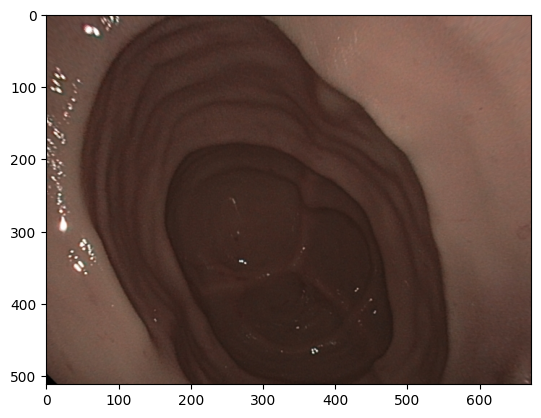

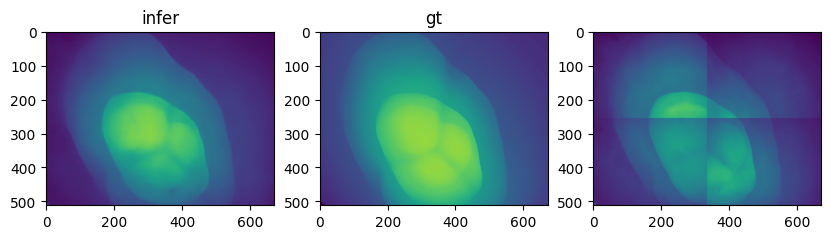

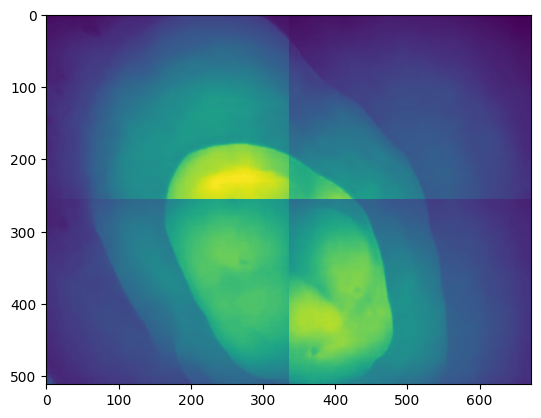

In [12]:
# C3VD 数据集
depth_anything = DepthAnythingV2(**{**model_configs['vits'], 'max_depth': 200})
# weight = torch.load("/home/jiahan/jiahan/codes/Depth-Anything-V2/tmp/2024-10-07_14-17-16/latest_4.pth", map_location='cpu') # aug 训练
weight = torch.load("/home/jiahan/jiahan/codes/Depth-Anything-V2/tmp/2024-10-11_14-53-03/latest_4.pth", map_location='cpu') # aug 训练，但是训练集图片数量为 0.8
if 'model' in weight.keys(): weight = weight['model']
else: pass

depth_anything.load_state_dict(weight)
depth_anything = depth_anything.to('cuda').eval()

img = cv2.imread("/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a/00045.jpg")
depth_gt = np.load("/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a/depth_gt/00045.npy")
show_one_swz(img, depth_gt, depth_anything, maxValue=100)


------ No stich -------
RMSE: 11.251566924007953
MAE: 7.928785934244204
ABS REL: 0.1555053695559379
------ stich -------
RMSE: 17.240543411807764
MAE: 12.053058921718238
ABS REL: 0.2434844307534749
------ diff infer -------
RMSE: 10.387382261512483
MAE: 6.6943632524926215
ABS REL: 0.15090413559825272
--------
=> LT
RMSE: 12.579878861565025
MAE: 8.853603351115456
ABS REL: 0.17167659342661284
diff infer
RMSE: 8.71300220489502
MAE: 6.156050682067871
ABS REL: 0.16683083772659302
=> RT
RMSE: 9.606032283814276
MAE: 7.503686392076103
ABS REL: 0.3063611896470611
diff infer
RMSE: 6.316883563995361
MAE: 4.5439324378967285
ABS REL: 0.1448824107646942
=> LD
RMSE: 22.77097292403058
MAE: 16.993972888214195
ABS REL: 0.2986617445172588
diff infer
RMSE: 13.698895454406738
MAE: 9.005918502807617
ABS REL: 0.17356547713279724
=> RD
RMSE: 20.49143558224864
MAE: 14.860973055467188
ABS REL: 0.1990248110434694
diff infer
RMSE: 11.318642616271973
MAE: 7.071552276611328
ABS REL: 0.12539000809192657


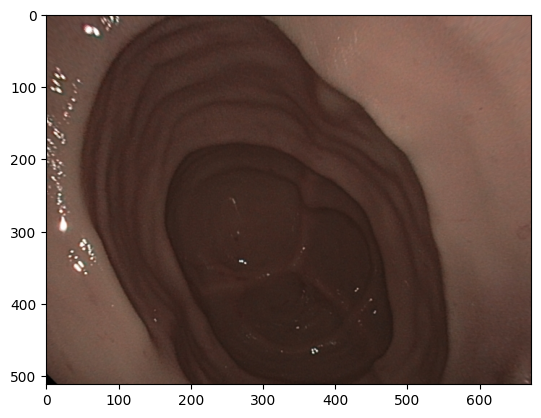

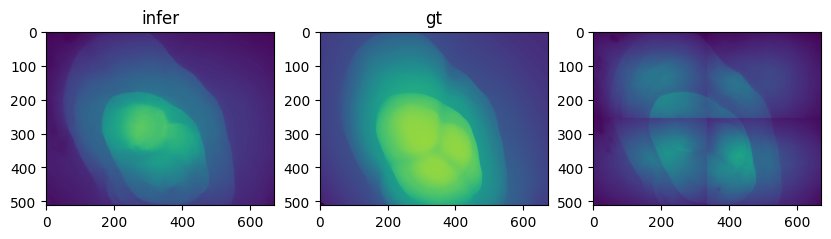

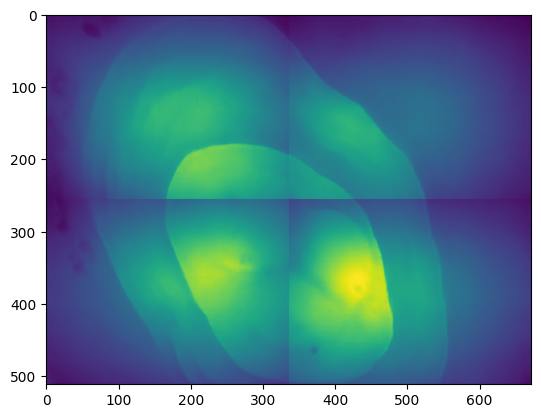

In [13]:
model_base = DepthAnythingV2(**{**model_configs['vits'], 'max_depth': 200})
weight = torch.load("/home/jiahan/jiahan/codes/Depth-Anything-V2/tmp/2024-10-08_21-14-04/latest_4.pth", map_location='cpu')
if 'model' in weight.keys(): weight = weight['model']
else: pass
model_base.load_state_dict(weight)
model_base = model_base.to('cuda').eval()

show_one_swz(img, depth_gt, model_base, maxValue=100)

RMSE: 4.105539321899414
MAE: 3.2141940593719482
ABS REL: 2443205.75
10.599991 ------- 8.9645386e-05


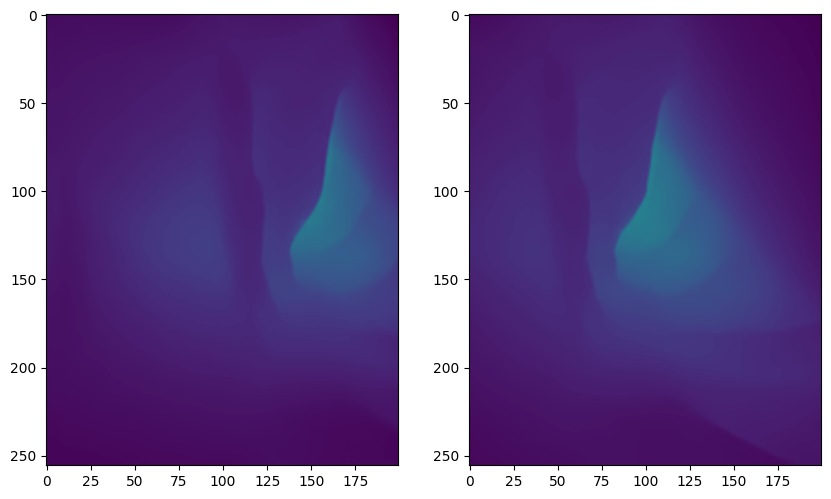

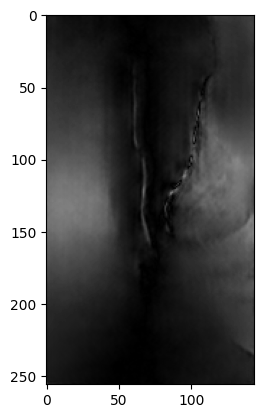

In [27]:
image_left = image[:, 0:200]
image_right = image[:, 256-200:]
depth_left = depth_anything.infer_image(image_left)
depth_right = depth_anything.infer_image(image_right)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(depth_left, vmax=200)
plt.subplot(1,2,2)
plt.imshow(depth_right, vmax=200)

diff = abs(depth_left[:, 56:]-depth_right[:, 0:200-56])
show_metric(diff, np.zeros_like(diff))

plt.figure()
plt.imshow(diff, vmax=20, cmap='gray')
print(diff.max(), "-------", diff.min())

### 整个数据集评估

In [70]:
gt_files, img_files = read_txt("/home/jiahan/jiahan/codes/Depth-Anything-V2/metric_depth/dataset/splits/UCL_aug/val.txt")

def eval_main(gt_files, img_files, depth_anything):
    eval_values = [] # [ [rmse,mae,absrel], ...,  ]
    eval_sc_values = [] # [ [ [rmse,mae,absrel], [rmse1,mae1,absrel1], [rmse2,mae2,absrel2], [rmse3,mae3,absrel3], [rmse4,mae4,absrel4] ] ]

    for gt_file, img_file in tzip(gt_files, img_files):
        gt = read_depth(gt_file)
        img = read_img(img_file)
        eval_tmp = eval(img, gt, depth_anything)
        metrics, metrics_LT, metrics_RT, metrics_LD, metrics_RD = eval_sc(img, gt, depth_anything)

        eval_values.append(eval_tmp)
        eval_sc_values.append([metrics, metrics_LT, metrics_RT, metrics_LD, metrics_RD])
        
    eval_array = np.array(eval_values)
    eval_sc_array = np.array(eval_sc_values)

    print("=> eval value")
    print("RMSE MAE AbsRel")
    print(eval_array.mean(axis=0))
    print("=============")

    print("=> eval sc")
    print("RMSE MAE AbsRel")
    print(eval_sc_array.mean(axis=0)[0])
    print("------")
    print("==> LT")
    print(eval_sc_array.mean(axis=0)[1])
    print("------")
    print("==> RT")
    print(eval_sc_array.mean(axis=0)[2])
    print("------")
    print("==> LD")
    print(eval_sc_array.mean(axis=0)[3])
    print("------")
    print("==> RD")
    print(eval_sc_array.mean(axis=0)[4])

In [63]:
eval_array = np.array(eval_values)
eval_sc_array = np.array(eval_sc_values)

print("=> eval value")
print("RMSE MAE AbsRel")
print(eval_array.mean(axis=0))
print("=============")

print("=> eval sc")
print("RMSE MAE AbsRel")
print(eval_sc_array.mean(axis=0)[0])
print("------")
print("==> LT")
print(eval_sc_array.mean(axis=0)[1])
print("------")
print("==> RT")
print(eval_sc_array.mean(axis=0)[2])
print("------")
print("==> LD")
print(eval_sc_array.mean(axis=0)[3])
print("------")
print("==> RD")
print(eval_sc_array.mean(axis=0)[4])

=> eval value
RMSE MAE AbsRel
[2.4687726  1.6169928  0.04647319]
=> eval sc
RMSE MAE AbsRel
[3.299337   2.1866126  0.06341296]
------
==> LT
[2.9830601  2.0997021  0.07281665]
------
==> RT
[3.6462066  2.5878873  0.07552376]
------
==> LD
[2.7976995  1.9655046  0.06926282]
------
==> RD
[2.984498   2.0933514  0.06332371]


In [72]:
model_aug = depth_anything`
model_base = DepthAnythingV2(**{**model_configs['vits'], 'max_depth': 200})
weight = torch.load("/home/jiahan/jiahan/codes/Depth-Anything-V2/tmp/2024-10-08_21-14-04/latest_4.pth", map_location='cpu')
if 'model' in weight.keys(): weight = weight['model']
else: pass
model_base.load_state_dict(weight)
model_base = model_base.to('cuda').eval()

print("=====================================")
print("============== aug ==================")
eval_main(gt_files, img_files, model_aug)

print("=====================================")
print("============== base ==================")
eval_main(gt_files, img_files, model_base)`

model_aug08 = DepthAnythingV2(**{**model_configs['vits'], 'max_depth': 200})
weight = torch.load("/home/jiahan/jiahan/codes/Depth-Anything-V2/tmp/2024-10-11_14-53-03/latest_4.pth", map_location='cpu')
if 'model' in weight.keys(): weight = weight['model']
else: pass
model_aug08.load_state_dict(weight)
model_aug08 = model_aug08.to('cuda').eval()

print("=====================================")
print("============== aug 0.8 trainset ==================")
eval_main(gt_files, img_files, model_aug08)

============== aug ==================


 37%|███▋      | 1213/3276 [03:39<06:13,  5.52it/s]


KeyboardInterrupt: 

### 检查真实息肉的结果

64.877106 9.426586
60.08784 17.41717


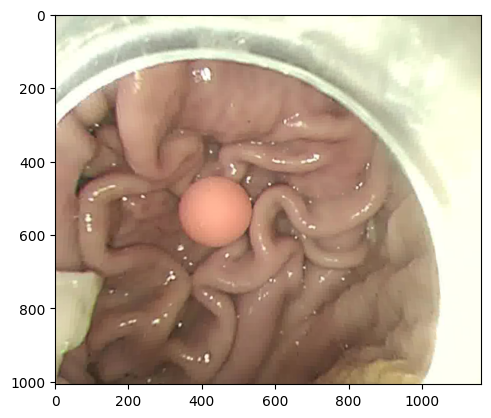

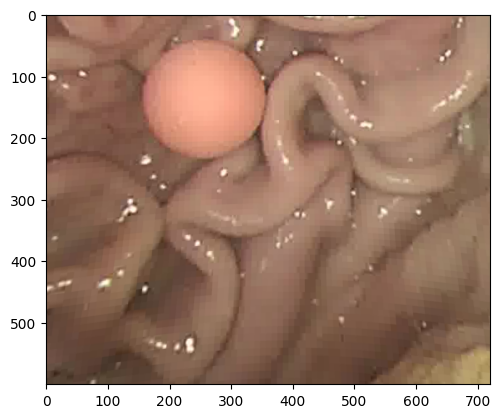

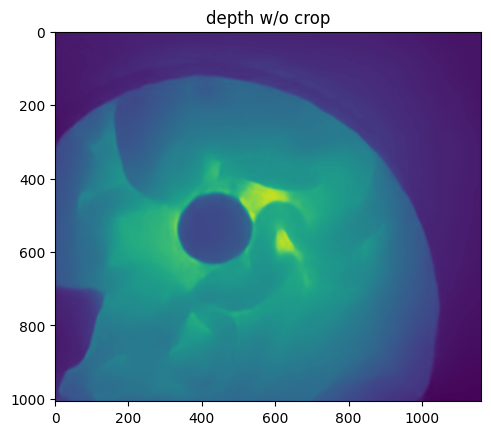

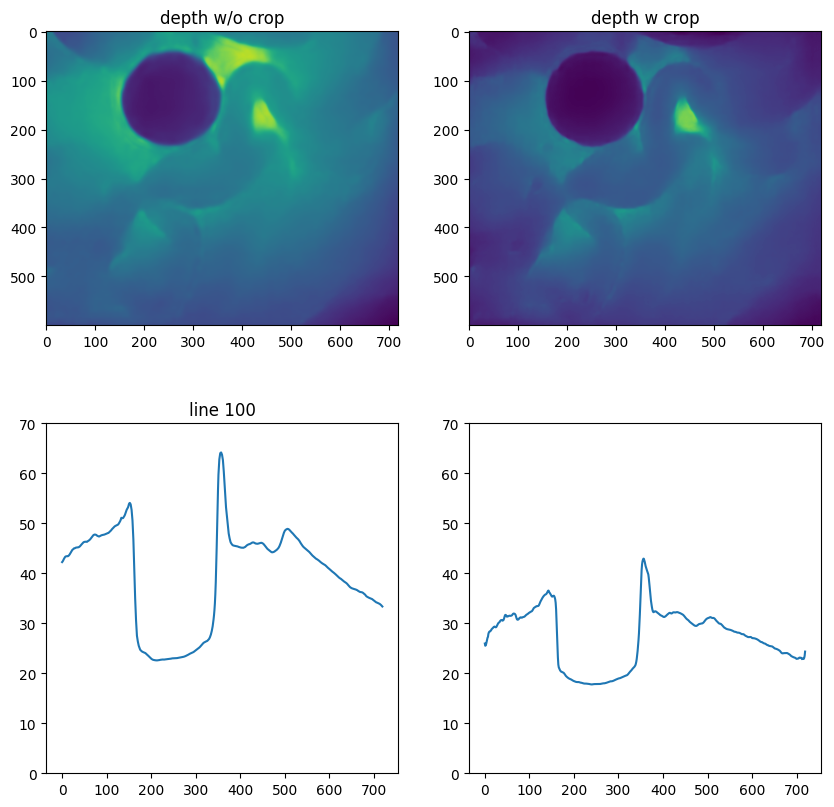

In [16]:
imgPath = "/home/jiahan/jiahan/datasets/Ours/240927_pig/240927_undist/16mm/16mm-橙色-扁平/frame_000022.png"
crop_x, crop_y = (180,900), (400,1000)

def crop(img, crop_x, crop_y):
    return img[crop_y[0]:crop_y[1], crop_x[0]:crop_x[1]]

img = cv2.imread(imgPath)
plt.imshow(img[...,::-1])
crop_img = img[crop_y[0]:crop_y[1], crop_x[0]:crop_x[1]]
plt.figure()
plt.imshow(crop_img[...,::-1])

# 使用crop训练的模型
depth_img = depth_anything.infer_image(img)
depth_crop = depth_anything.infer_image(crop_img)

print(depth_img.max(), depth_img.min())
print(depth_crop.max(), depth_crop.min())
plt.figure()
plt.title("depth w/o crop")
plt.imshow(depth_img, vmax=70)
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("depth w/o crop")
plt.imshow(crop(depth_img, crop_x, crop_y), vmax=70)
plt.subplot(2,2,2)
plt.title("depth w crop")
plt.imshow(depth_crop, vmax=70)
plt.subplot(2,2,3)
plt.title("line 100")
plt.ylim(0, 70)
plt.plot(crop(depth_img, crop_x, crop_y)[100])
plt.subplot(2,2,4)
plt.ylim(0, 70)
plt.plot(depth_crop[100])

65.79152 9.756237
52.23946 12.35318


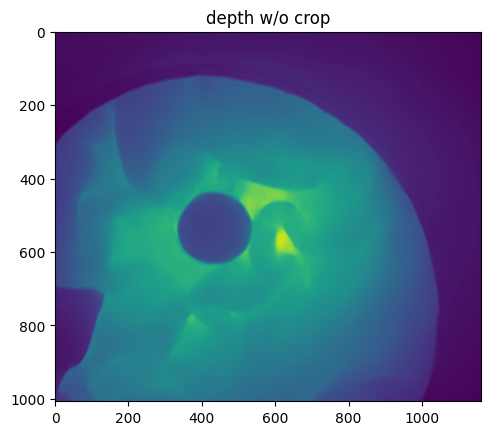

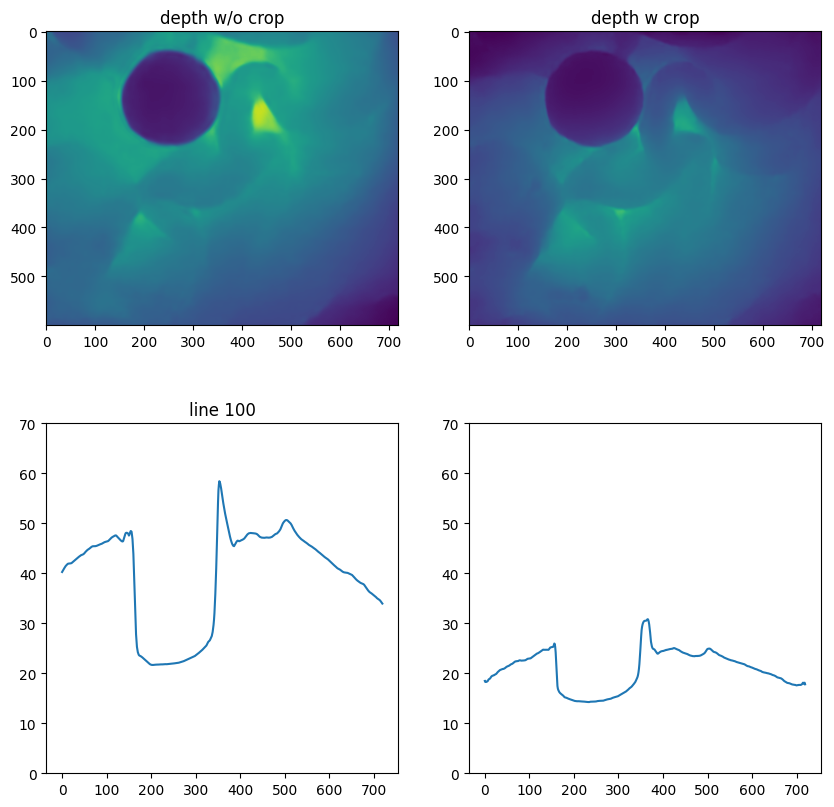

In [17]:
model_base = DepthAnythingV2(**{**model_configs['vits'], 'max_depth': 200})
weight = torch.load("/home/jiahan/jiahan/codes/Depth-Anything-V2/tmp/2024-10-08_21-14-04/latest_4.pth", map_location='cpu')
if 'model' in weight.keys(): weight = weight['model']
else: pass
model_base.load_state_dict(weight)
model_base = model_base.to('cuda').eval()

# 使用crop训练的模型
depth_img = model_base.infer_image(img)
depth_crop = model_base.infer_image(crop_img)

print(depth_img.max(), depth_img.min())
print(depth_crop.max(), depth_crop.min())
plt.figure()
plt.title("depth w/o crop")
plt.imshow(depth_img, vmax=70)
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("depth w/o crop")
plt.imshow(crop(depth_img, crop_x, crop_y), vmax=70)
plt.subplot(2,2,2)
plt.title("depth w crop")
plt.imshow(depth_crop, vmax=70)
plt.subplot(2,2,3)
plt.title("line 100")
plt.ylim(0, 70)
plt.plot(crop(depth_img, crop_x, crop_y)[100])
plt.subplot(2,2,4)
plt.ylim(0, 70)
plt.plot(depth_crop[100])

### 随机选点比较排序是否相符

In [15]:
import cv2
import random
import matplotlib.pyplot as plt

def selectPairPoints(img, num):
    h,w,_ = img.shape
    points = []
    for _ in range(num):
        x1,y1 = random.randint(0, w-1), random.randint(0, h-1)
        x2,y2 = random.randint(0, w-1), random.randint(0, h-1)
        points.append( ((x1,y1), (x2,y2)) )
    return points

def showPointsInImg(img, point, color=(255,0,0)):
    cv2.circle(img, point[0], 2, (128,245,12), -1)
    cv2.circle(img, point[1], 2, (128,245,12), -1)
    cv2.line(img, point[0], point[1], color=color, thickness=1)
    return img

def checkEqual(depth, depth_gt, point):
    h,w = depth.shape
    depth1 = depth[point[0][1], point[0][0]]
    depth2 = depth[point[1][1], point[1][0]]
    depth_gt1 = depth_gt[point[0][1], point[0][0]]
    depth_gt2 = depth_gt[point[1][1], point[1][0]]

    return (depth1-depth2) * (depth_gt1-depth_gt2) > 0
    

0.1113


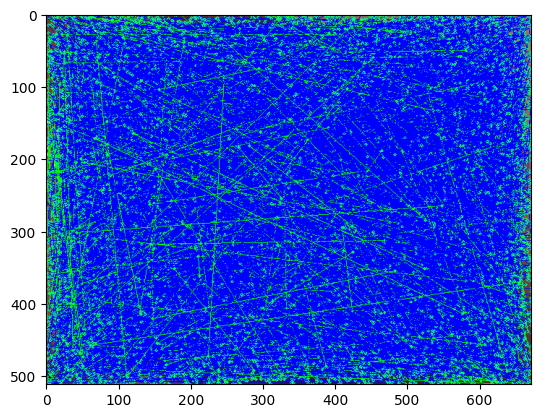

In [135]:
depth_anything = DepthAnythingV2(**{**model_configs['vits'], 'max_depth': 200})
weight = torch.load("/home/jiahan/jiahan/codes/Depth-Anything-V2/tmp/2024-10-07_14-17-16/latest_4.pth", map_location='cpu')
if 'model' in weight.keys(): weight = weight['model']
else: pass
depth_anything.load_state_dict(weight)
depth_anything = depth_anything.to('cuda').eval()

img = cv2.imread("/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a/00045.jpg")
depth_gt = np.load("/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a/depth_gt/00045.npy")

# img = cv2.imread("/Disk_2/Jiahan/T1/C_T3_L3_5_resized/FrameBuffer_0478.png")
# depth_gt = 200 * cv2.imread("/Disk_2/Jiahan/T1/C_T3_L3_5_resized/Depth_0478.png", -1).astype(np.float32) / 255.0

# depth = depth_anything.infer_image(img)
depth = infer_stich(depth_anything, img, depth_gt)

pointsCount = 10000
pointsError = 0

points = selectPairPoints(img, pointsCount)
for point in points:
    ck = checkEqual(depth, depth_gt, point)
    if ck: showPointsInImg(img, point)
    else: 
        showPointsInImg(img, point, color=(0,255,0))
        pointsError += 1

plt.imshow(img[...,::-1])

print(pointsError / pointsCount)

0.2269


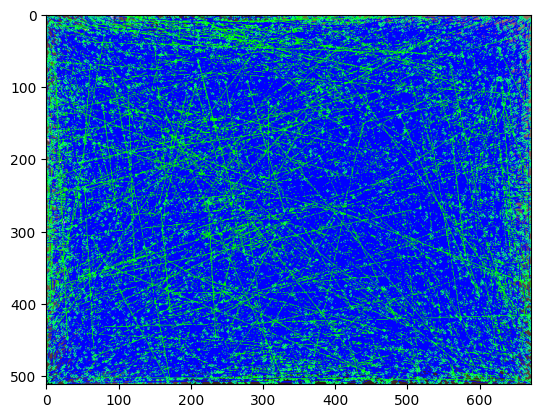

In [132]:
model_base = DepthAnythingV2(**{**model_configs['vits'], 'max_depth': 200})
weight = torch.load("/home/jiahan/jiahan/codes/Depth-Anything-V2/tmp/2024-10-08_21-14-04/latest_4.pth", map_location='cpu')
if 'model' in weight.keys(): weight = weight['model']
else: pass
model_base.load_state_dict(weight)
model_base = model_base.to('cuda').eval()


img = cv2.imread("/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a/00045.jpg")
depth_gt = np.load("/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a/depth_gt/00045.npy")

# img = cv2.imread("/Disk_2/Jiahan/T1/C_T3_L3_5_resized/FrameBuffer_0478.png")
# depth_gt = 200 * cv2.imread("/Disk_2/Jiahan/T1/C_T3_L3_5_resized/Depth_0478.png", -1).astype(np.float32) / 255.0

# depth = depth_anything.infer_image(img)
depth = infer_stich(model_base, img, depth_gt)


pointsCount = 10000
pointsError = 0

points = selectPairPoints(img, pointsCount)
for point in points:
    ck = checkEqual(depth, depth_gt, point)
    if ck: showPointsInImg(img, point)
    else: 
        showPointsInImg(img, point, color=(0,255,0))
        pointsError += 1

plt.imshow(img[...,::-1])

print(pointsError / pointsCount)